<a href="https://colab.research.google.com/github/caroref/final/blob/master/S2_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import random
import shutil

import tensorflow as tf
import tensorflow_hub as hub
print("TensorFlow version is ", tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

W0604 15:03:24.246975 139833862203264 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


TensorFlow version is  1.13.1


In [2]:
# Allow Colab to access drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

#linking Colab to use drive as if local
!mkdir -p drive
!google-drive-ocamlfuse drive


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
#main directories
base_dir = 'drive/Colab/EV/Base/'
like = os.path.join(base_dir, 'Like')
dislike = os.path.join(base_dir, 'Dislike')

trn_dir = 'drive/Colab/EV/S2/Train/'
tst_dir = 'drive/Colab/EV/S2/Test/'

#subdirectories
trn_like = os.path.join(trn_dir, 'Like')
tst_like = os.path.join(tst_dir, 'Like')

trn_disl = os.path.join(trn_dir, 'Dislike')
tst_disl = os.path.join(tst_dir, 'Dislike')


# Data Preprocessing

In [0]:
# All images will be resized to image_size

image_size = 640 
batch_size = 100

# create Image Data Generator for Image Data Augmentation

train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255, 
                validation_split=0.2)


In [5]:
# Create the train and validation generators and specify the train dataset directory, 
# image size, batch size, binary classification, and subset (training or validation).


# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                trn_dir,  
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode ='binary',
                subset = 'training') 

Found 400 images belonging to 2 classes.


In [6]:
# Flow validation images in batches using validation_datagen generator
validation_generator = train_datagen.flow_from_directory(
                trn_dir,
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary',
                subset = 'validation')

Found 100 images belonging to 2 classes.


# Create the base model from the pre-trained convnets

Using the output of last layer (bottleneck layer). Keep other layers frozen (these are specific to their training, less useful here?) Bottleneck layer should be more general.

Using Inception v3 model with weights trained on ImageNet.
The argument, include_top=False, means that we have a network that isn't including classification layers at the top. This is good for feature extraction.

In [7]:
IMG_SHAPE = (image_size, image_size, 3)

base_model = keras.applications.inception_v3.InceptionV3(
             include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

Instructions for updating:
Colocations handled automatically by placer.


W0604 15:04:22.232720 139833862203264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


87916544/87910968 [==============================] - 4s 0us/step


# Feature extraction
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [8]:
#freeze base

base_model.trainable = False

# Look at the base model architecture
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 319, 319, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 319, 319, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 319, 319, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
#add a classification head
#adding a few layers on top of the base model

model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')])

#relatively basic layer. no deep neural networks (all happening beforehand). Similar to a logit regression. plain classification


In [10]:
#Compile the model (Must do before training!)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 18, 18, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
#These 2K trainable parameters are divided among 2 TensorFlow Variable objects, the weights and biases of the two dense layers:


len(model.trainable_variables)

2

**Train the model**


In [12]:
epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.


W0604 15:04:39.903042 139833862203264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/200
4/4 [==============================] - 136s 34s/step - loss: 0.7556 - acc: 0.5000 - val_loss: 0.7231 - val_acc: 0.4900
Epoch 2/200
4/4 [==============================] - 12s 3s/step - loss: 0.7173 - acc: 0.4825 - val_loss: 0.7138 - val_acc: 0.4200
Epoch 3/200
4/4 [==============================] - 13s 3s/step - loss: 0.7075 - acc: 0.4750 - val_loss: 0.7108 - val_acc: 0.4400
Epoch 4/200
4/4 [==============================] - 12s 3s/step - loss: 0.7057 - acc: 0.4675 - val_loss: 0.7095 - val_acc: 0.4500
Epoch 5/200
4/4 [==============================] - 12s 3s/step - loss: 0.7037 - acc: 0.4775 - val_loss: 0.7089 - val_acc: 0.4300
Epoch 6/200
4/4 [==============================] - 13s 3s/step - loss: 0.7011 - acc: 0.4775 - val_loss: 0.7083 - val_acc: 0.4500
Epoch 7/200
4/4 [==============================] - 13s 3s/step - loss: 0.7005 - acc: 0.4950 - val_loss: 0.7080 - val_acc: 0.4500
Epoch 8/200
4/4 [==============================] - 13s 3s/step - loss: 0.7004 - acc: 0.4600 - v

**Learning curves**




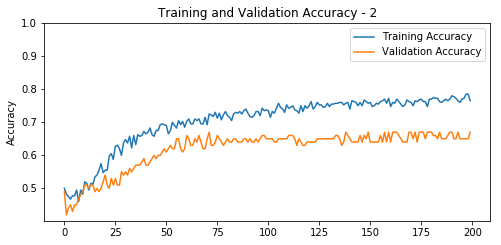

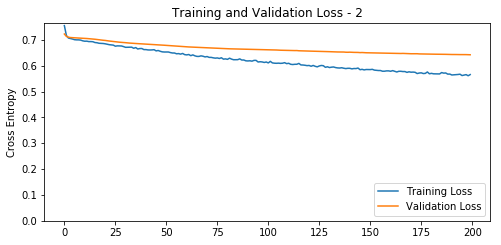

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

#get number of epochs
epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy - 2')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss - 2')
plt.show()

In [14]:
_, acc = model.evaluate_generator(generator=train_generator)
print('Accuracy on training set: {}%'.format(round(acc, 3)*100))

_, acc = model.evaluate_generator(generator=validation_generator)
print('Accuracy on validation set: {}%'.format(round(acc, 3)*100))



Accuracy on training set: 77.49999761581421%
Accuracy on validation set: 67.00000166893005%


**Export Model**

In [0]:
# keras library import  for Saving and loading model and weights
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

In [0]:
# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("drive/Colab Notebooks/smodel/s2_model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("drive/Colab Notebooks/smodel/s2_model_num.h5")
model.save('drive/Colab Notebooks/smodel/s2_model_num.hdf5')